In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import quad
from scipy.optimize import minimize
from functools import lru_cache
from numpy.linalg import inv
from IPython.display import display, Math
from scipy.optimize import approx_fprime
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.linear_model import LinearRegression
import time
import os
from scipy.stats import gamma
from scipy.special import erf, gammaincinv
from IPython.display import Markdown, display
import pickle


In [2]:
start_time = time.time()

# Load Pantheon+ light curve data
pantheon_data = pd.read_csv("lcparam_full_long_zhel-pp.txt", delim_whitespace=True, comment='#')

# Load and reshape the covariance matrix
with open("sys_full_long-pp.txt", "r") as f:
    lines = f.readlines()

N = int(lines[0].strip())  # Size of the matrix
flat_data = np.array([float(x.strip()) for x in lines[1:]])
C_full = flat_data.reshape((N, N))
C_inv = np.linalg.inv(C_full)  # Invert the full covariance matrix
# Load Hubble Diagram Redshift from PANTHEON
z = pantheon_data['zHD'].values
# Define SNe with Cepheid host
is_calibrator = pantheon_data['IS_CALIBRATOR'].values.astype(int)
# Load the corrected apparent magnitudes and distance moduli from Cepheid hosts
mB = pantheon_data['m_b_corr'].values
mu_Ceph = pantheon_data['CEPH_DIST'].values
# Speed of light in km/s
c_km_s = 299792.458 

end_time = time.time()
print(f"⏱️ Execution time: {end_time - start_time:.2f} seconds")

/var/tmp/stamou/ipykernel_1536295/911792637.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  pantheon_data = pd.read_csv("lcparam_full_long_zhel-pp.txt", delim_whitespace=True, comment='#')


⏱️ Execution time: 1.13 seconds


# MCMC via emcee
## Transition in $M$

In [3]:
# --- CPL Expansion Function ---
def E_CPL(z, Omega_m, w0, wa):
    """Dimensionless Hubble parameter E(z) = H(z)/H0 for CPL model."""
    term1 = Omega_m * (1 + z)**3
    term2 = (1 - Omega_m) * (1 + z)**(3 * (1 + w0 + wa)) * np.exp(-3 * wa * z / (1 + z))
    return np.sqrt(term1 + term2)

# --- Integral for d_L(z) with caching ---
@lru_cache(maxsize=None)
def integral_dL_CPL(z, H0, Omega_m, w0, wa):
    integrand = lambda zp: 1.0 / E_CPL(zp, Omega_m, w0, wa)
    integral, _ = quad(integrand, 0, z)
    return (1 + z) * c_km_s * integral / H0

# --- Distance Modulus from CPL ---
def mu_theory_CPL(z_array, H0, Omega_m, w0, wa):
    """Compute theoretical distance modulus for array of z in CPL model."""
    return np.array([
        5 * np.log10(integral_dL_CPL(float(z), H0, Omega_m, w0, wa)) + 25
        for z in z_array
    ])


In [6]:
# --- Chi-square for CPL + M-transition ---
def chi2_transition_CPL(params, z, mB, mu_Ceph, is_calibrator, C_inv):
    """
    Compute chi2 for CPL + M transition model (with floating d_crit).
    """
    M_low, M_high, H0, Omega_m, w0, wa, d_crit = params

    # Model distance modulus
    mu_model = mu_theory_CPL(z, H0, Omega_m, w0, wa)
    
    # SH0ES proxy
    mu_SH0ES = mB + 19.253
    mu_crit = 5 * np.log10(d_crit) + 25

    # Select M value based on proxy threshold
    M_used = np.where(mu_SH0ES < mu_crit, M_low, M_high)

    # Construct residuals
    Q = np.where(
        is_calibrator == 1,
        mB - M_used - mu_Ceph,
        mB - M_used - mu_model
    )
    
    return Q.T @ C_inv @ Q

# --- Flat Priors for emcee sampling ---
priors_CPL_transition = {
    'M_low': (-20.0, -18.0),
    'M_high': (-20.0, -18.0),
    'H0': (60.0, 85.0),
    'Omega_m': (0.1, 0.5),
    'w0': (-2.0, 0.0),
    'wa': (-2.0, 2.0),
    'd_crit': (15.0, 25.0)
}

# --- Log Posterior ---
def log_posterior_CPL_transition(params, z, mB, mu_Ceph, is_calibrator, C_inv, priors):
    """
    Compute log-posterior for CPL + transition model:
    - Flat priors from dictionary
    - Gaussian likelihood from chi-square
    """
    # Unpack prior bounds
    for val, (low, high) in zip(params, priors.values()):
        if not (low <= val <= high):
            return -np.inf  # zero probability outside prior

    # Log-likelihood
    chi2_val = chi2_transition_CPL(params, z, mB, mu_Ceph, is_calibrator, C_inv)
    return -0.5 * chi2_val


In [5]:
import time
import numpy as np
import emcee
import multiprocessing
import pickle

start_time = time.time()

def run_emcee_CPL_transition(z, mB, mu_Ceph, is_calibrator, C_inv, priors,
                              n_walkers=32, n_steps=5000, burn_in=1000):

    ndim = 7  # Parameters: M_low, M_high, H0, Omega_m, w0, wa, d_crit

    # --- Initialize walkers uniformly within prior bounds ---
    np.random.seed(42)
    initial_positions = np.array([
        [
            np.random.uniform(*priors['M_low']),
            np.random.uniform(*priors['M_high']),
            np.random.uniform(*priors['H0']),
            np.random.uniform(*priors['Omega_m']),
            np.random.uniform(*priors['w0']),
            np.random.uniform(*priors['wa']),
            np.random.uniform(*priors['d_crit'])
        ]
        for _ in range(n_walkers)
    ])

    # --- Parallel emcee sampling ---
    with multiprocessing.Pool() as pool:
        sampler = emcee.EnsembleSampler(
            n_walkers,
            ndim,
            log_posterior_CPL_transition,
            args=(z, mB, mu_Ceph, is_calibrator, C_inv, priors),
            pool=pool
        )

        sampler.run_mcmc(initial_positions, n_steps, progress=True)

    # --- Flatten and save chain after burn-in ---
    samples = sampler.get_chain(discard=burn_in, flat=True)
    np.save("samples_CPL_transition_5000steps.npy", samples)
    np.save("full_chain_CPL_transition.npy", sampler.get_chain())
    # --- Save full sampler object using pickle ---
    with open("sampler_CPL_transition.pkl", "wb") as f:
        pickle.dump(sampler, f)    

    return samples, sampler

# Run it
samples_CPL_transition, sampler_CPL_transition = run_emcee_CPL_transition(
    z,
    mB,
    mu_Ceph,
    is_calibrator,
    C_inv,
    priors_CPL_transition,
    n_walkers=32,
    n_steps=5000,
    burn_in=1000
)

end_time = time.time()
print(f"⏱️ Execution time: {end_time - start_time:.2f} seconds")


100%|█████████████████████████████████████| 5000/5000 [4:11:43<00:00,  3.02s/it]


⏱️ Execution time: 15113.00 seconds


In [12]:
# --- Load the saved sampler object ---
with open("sampler_CPL_transition.pkl", "rb") as f:
    sampler = pickle.load(f)

# --- Parameter names for display ---
param_names = ["M_low", "M_high", "H0", "Omega_m", "w0", "wa", "d_crit"]

# --- Try computing autocorrelation time and N_eff ---
try:
    tau = sampler.get_autocorr_time(tol=0)
    print("Autocorrelation time per parameter:")
    for name, t in zip(param_names, tau):
        print(f"  {name:<9s}: τ = {t:.1f} steps")

    # Effective sample size: N_eff = total samples / τ
    n_walkers, n_steps, _ = sampler.chain.shape
    n_eff = (n_walkers * n_steps) / tau

    print("\nEffective sample size per parameter:")
    for name, n in zip(param_names, n_eff):
        print(f"  {name:<9s}: N_eff ≈ {int(n):,}")

except emcee.autocorr.AutocorrError:
    print("⚠️ Autocorrelation time could not be reliably estimated. Consider increasing the number of steps.")


Autocorrelation time per parameter:
  M_low    : τ = 93.3 steps
  M_high   : τ = 83.5 steps
  H0       : τ = 107.6 steps
  Omega_m  : τ = 226.5 steps
  w0       : τ = 185.9 steps
  wa       : τ = 183.2 steps
  d_crit   : τ = 120.0 steps

Effective sample size per parameter:
  M_low    : N_eff ≈ 1,715
  M_high   : N_eff ≈ 1,916
  H0       : N_eff ≈ 1,486
  Omega_m  : N_eff ≈ 706
  w0       : N_eff ≈ 860
  wa       : N_eff ≈ 873
  d_crit   : N_eff ≈ 1,333


In [8]:
# --- Load sampler object ---
with open("sampler_CPL_transition.pkl", "rb") as f:
    sampler = pickle.load(f)

# --- Extract log-probabilities and flattened chain (after burn-in) ---
log_prob = sampler.get_log_prob(discard=1000, flat=True)
flat_samples = sampler.get_chain(discard=1000, flat=True)

# --- MAP ---
map_index = np.argmax(log_prob)
map_params = flat_samples[map_index]

# --- Median, mean, uncertainty ---
median_params = np.median(flat_samples, axis=0)
means = np.mean(flat_samples, axis=0)
lower = np.percentile(flat_samples, 16, axis=0)
upper = np.percentile(flat_samples, 84, axis=0)
uncertainties = 0.5 * (upper - lower)

# --- Parameter names and units ---
param_names = ["M_low", "M_high", "H0", "Omega_m", "w0", "wa", "d_crit"]
units = ["", "", "km/s/Mpc", "", "", "", "Mpc"]

# --- Print results ---
print(f"{'Parameter':<15} {'MAP':>10} {'Median':>10} {'Mean':>10} {'±1σ':>12} {'Unit':>10}")
print("-" * 75)

for name, map_val, med_val, mean, err, unit in zip(param_names, map_params, median_params, means, uncertainties, units):
    print(f"{name:<15} {map_val:>10.4f} {med_val:>10.4f} {mean:>10.4f} ±{err:>6.4f} {unit:>10}")


Parameter              MAP     Median       Mean          ±1σ       Unit
---------------------------------------------------------------------------
M_low             -19.3973   -19.4008   -19.4017 ±0.0561           
M_high            -19.2173   -19.2104   -19.2108 ±0.0313           
H0                 74.2495    74.5647    74.5679 ±1.1137   km/s/Mpc
Omega_m             0.2150     0.3295     0.3135 ±0.0870           
w0                 -0.8060    -0.9261    -0.9363 ±0.1396           
wa                  0.3192    -0.3291    -0.3687 ±0.9726           
d_crit             19.9508    19.5032    19.6637 ±0.7938        Mpc


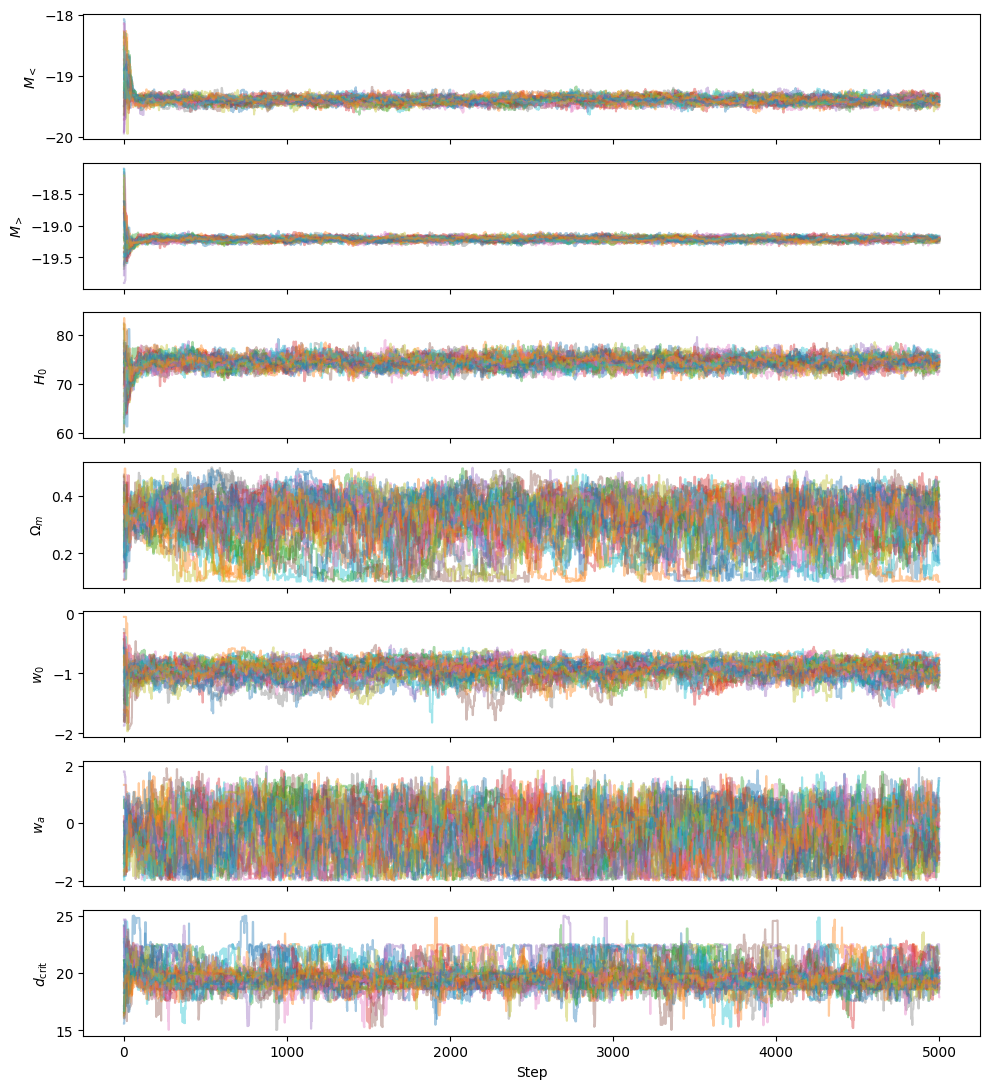

In [6]:
# Load samples and full chain
samples = np.load("samples_CPL_transition_5000steps.npy")
full_chain = np.load("full_chain_CPL_transition.npy")

# Parameter labels for CPL + transition model
param_labels = [
    r"$M_{<}$", r"$M_{>}$", r"$H_0$", r"$\Omega_m$", 
    r"$w_0$", r"$w_a$", r"$d_{\mathrm{crit}}$"
]

# Create chain plot
fig, axes = plt.subplots(7, figsize=(10, 11), sharex=True)

for i in range(7):
    for walker in range(full_chain.shape[1]):
        axes[i].plot(full_chain[:, walker, i], alpha=0.4)
    axes[i].set_ylabel(param_labels[i])

axes[-1].set_xlabel("Step")
plt.tight_layout()

# Save to file
fig.savefig("chain_plot_CPL_transition.png", dpi=300)
plt.show()


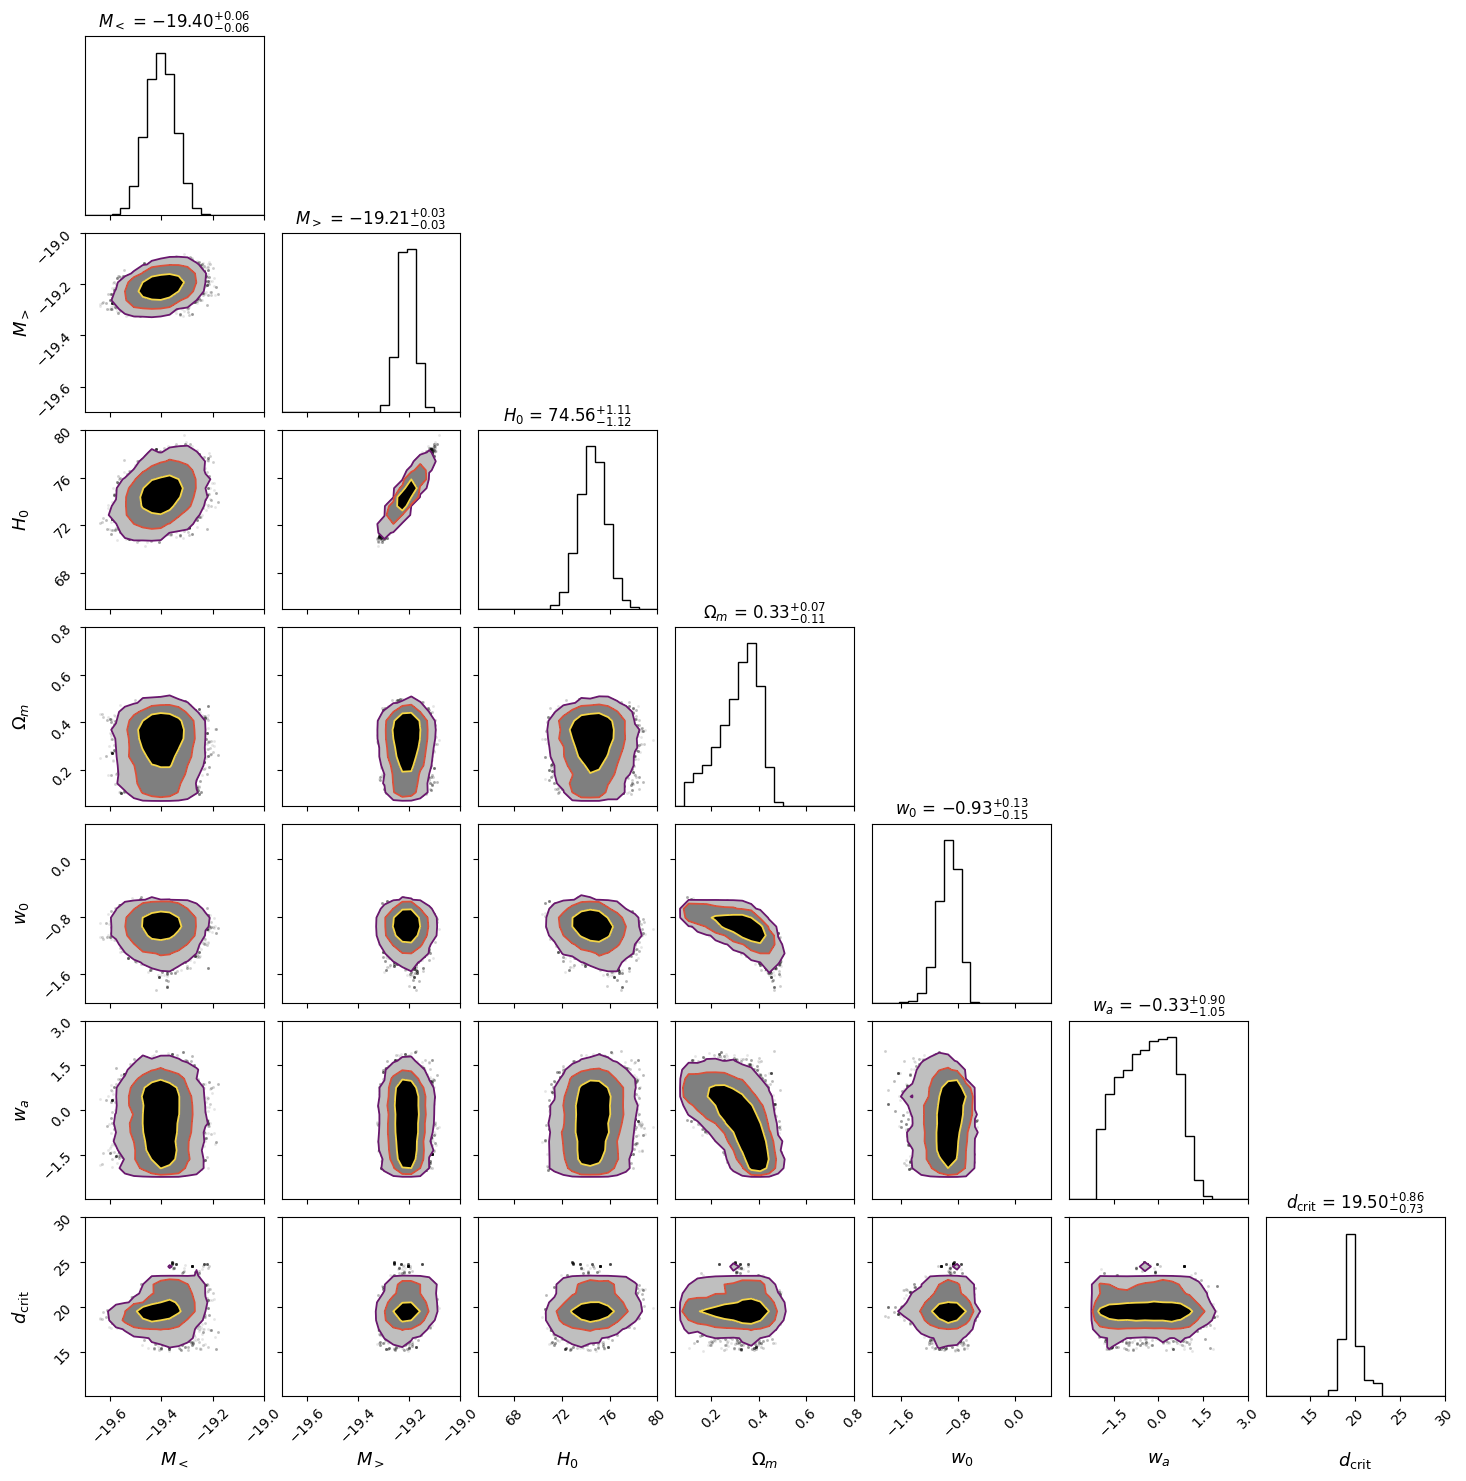

In [14]:
import corner
# Load samples
samples = np.load("samples_CPL_transition_5000steps.npy")

# Parameter labels for CPL + transition model
param_labels = [
    r"$M_{<}$", 
    r"$M_{>}$", 
    r"$H_0$", 
    r"$\Omega_m$", 
    r"$w_0$", 
    r"$w_a$", 
    r"$d_{\mathrm{crit}}$"
]

# Confidence levels
levels = [0.68, 0.95, 0.997]

# Colormap and contour colors
cmap = plt.colormaps["inferno"]
colors = [cmap(i) for i in np.linspace(0.3, 0.9, len(levels))]

# Axis ranges (can adjust if needed)
ranges = [
    (-19.7, -19.0),   # M_<
    (-19.7, -19.0),   # M_>
    (65, 80),         # H_0
    (0.05, 0.80),     # Omega_m
    (-2.0, 0.5),     # w0
    (-3.0, 3.0),      # wa
    (10, 30)          # d_crit
]

# Create corner plot
fig_cpl = corner.corner(
    samples,
    labels=param_labels,
    show_titles=True,
    title_fmt=".2f",
    levels=levels,
    plot_contours=True,
    fill_contours=True,
    range=ranges,
    contour_kwargs={"colors": colors, "linewidths": 1.3},
    hist_kwargs={"color": colors[0], "edgecolor": "black"},
    label_kwargs={"fontsize": 13},
    title_kwargs={"fontsize": 12},
    max_n_ticks=4,
    use_math_text=True
)

# Adjust layout
plt.subplots_adjust(top=0.95, bottom=0.1, left=0.1, right=0.95, hspace=0.1, wspace=0.1)

# Save plot
fig_cpl.savefig("corner_plot_CPL_transition.png", dpi=300)
plt.show()


In [10]:
from IPython.display import display, Math
import numpy as np

# Labels and units for CPL model
param_labels = [
    r"M_{<}", r"M_{>}", r"H_0", r"\Omega_m", 
    r"w_0", r"w_a", r"d_{\mathrm{crit}}"
]
units = [
    "", "", r"\,\mathrm{km/s/Mpc}", "", "", "", r"\,\mathrm{Mpc}"
]

# Compute posterior stats
medians = np.median(samples, axis=0)
lower = np.percentile(samples, 16, axis=0)
upper = np.percentile(samples, 84, axis=0)

# Display in LaTeX format
display(Math(r"\textbf{Posterior medians with 68\% CI:}"))
for i in range(len(param_labels)):
    median = medians[i]
    err_minus = median - lower[i]
    err_plus = upper[i] - median
    display(Math(
        rf"{param_labels[i]} = {median:.3f}^{{+{err_plus:.3f}}}_{{-{err_minus:.3f}}}{units[i]}"
    ))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## No-Transition in $M$

In [9]:
# --- Chi-square for CPL model (no M transition) ---
def chi2_CPL_no_transition(params, z, mB, mu_Ceph, is_calibrator, C_inv):
    """
    Compute chi-square for CPL model without transition in M.
    """
    M, H0, Omega_m, w0, wa = params

    # Theoretical distance modulus
    mu_model = mu_theory_CPL(z, H0, Omega_m, w0, wa)

    # Residual vector Q
    Q = np.where(
        is_calibrator == 1,
        mB - M - mu_Ceph,
        mB - M - mu_model
    )

    return Q.T @ C_inv @ Q

# --- Flat priors for CPL no-transition model ---
priors_CPL_no_transition = {
    'M': (-20.0, -18.0),
    'H0': (60.0, 85.0),
    'Omega_m': (0.1, 0.5),
    'w0': (-2.0, 0.0),
    'wa': (-2.0, 2.0)
}

# --- Log-posterior for CPL no-transition ---
def log_posterior_CPL_no_transition(params, z, mB, mu_Ceph, is_calibrator, C_inv, priors):
    """
    Log-posterior for CPL model with no M transition:
    - Flat priors
    - Gaussian likelihood via chi-square
    """
    # Prior bounds check
    for val, (low, high) in zip(params, priors.values()):
        if not (low <= val <= high):
            return -np.inf

    # Compute log-likelihood
    chi2_val = chi2_CPL_no_transition(params, z, mB, mu_Ceph, is_calibrator, C_inv)
    return -0.5 * chi2_val

In [8]:
import emcee
import multiprocessing
import pickle
start_time = time.time()

def run_emcee_CPL_no_transition(z, mB, mu_Ceph, is_calibrator, C_inv, priors,
                                n_walkers=32, n_steps=5000, burn_in=1000):

    ndim = 5  # Parameters: M, H0, Omega_m, w0, wa

    # --- Initialize walkers within prior bounds ---
    np.random.seed(42)
    initial_positions = np.array([
        [
            np.random.uniform(*priors['M']),
            np.random.uniform(*priors['H0']),
            np.random.uniform(*priors['Omega_m']),
            np.random.uniform(*priors['w0']),
            np.random.uniform(*priors['wa'])
        ]
        for _ in range(n_walkers)
    ])

    # --- Parallel emcee sampling ---
    with multiprocessing.Pool() as pool:
        sampler = emcee.EnsembleSampler(
            n_walkers,
            ndim,
            log_posterior_CPL_no_transition,
            args=(z, mB, mu_Ceph, is_calibrator, C_inv, priors),
            pool=pool
        )

        sampler.run_mcmc(initial_positions, n_steps, progress=True)

    # --- Flatten and save chain after burn-in ---
    samples = sampler.get_chain(discard=burn_in, flat=True)
    np.save("samples_CPL_no_transition_5000steps.npy", samples)
    np.save("full_chain_CPL_no_transition.npy", sampler.get_chain())
    # --- Save full sampler object using pickle ---
    with open("sampler_CPL_notransition.pkl", "wb") as f:
        pickle.dump(sampler, f) 
    return samples, sampler

# Run it
samples_CPL_no_transition, sampler_CPL_no_transition = run_emcee_CPL_no_transition(
    z,
    mB,
    mu_Ceph,
    is_calibrator,
    C_inv,
    priors_CPL_no_transition,
    n_walkers=32,
    n_steps=5000,
    burn_in=1000
)

end_time = time.time()
print(f"⏱️ Execution time: {end_time - start_time:.2f} seconds")


100%|█████████████████████████████████████| 5000/5000 [4:11:37<00:00,  3.02s/it]


⏱️ Execution time: 15107.54 seconds


In [11]:
# --- Load sampler object ---
with open("sampler_CPL_notransition.pkl", "rb") as f:
    sampler = pickle.load(f)

# --- Parameter names (optional, for readability) ---
param_names = ["M", "H0", "Omega_m", "w0", "wa"]

# --- Try to estimate autocorrelation time and effective sample size ---
try:
    tau = sampler.get_autocorr_time(tol=0)
    print("Autocorrelation time per parameter:")
    for name, t in zip(param_names, tau):
        print(f"  {name:<9s}: τ = {t:.1f} steps")

    # Effective sample size: N_eff = total_samples / τ
    n_walkers, n_steps, _ = sampler.chain.shape
    n_eff = (n_walkers * n_steps) / tau
    print("\nEffective sample size per parameter:")
    for name, n in zip(param_names, n_eff):
        print(f"  {name:<9s}: N_eff ≈ {int(n):,}")

except emcee.autocorr.AutocorrError:
    print("⚠️ Autocorrelation time could not be reliably estimated. Consider running more steps.")



Autocorrelation time per parameter:
  M        : τ = 55.7 steps
  H0       : τ = 66.7 steps
  Omega_m  : τ = 141.0 steps
  w0       : τ = 102.7 steps
  wa       : τ = 107.2 steps

Effective sample size per parameter:
  M        : N_eff ≈ 2,870
  H0       : N_eff ≈ 2,399
  Omega_m  : N_eff ≈ 1,134
  w0       : N_eff ≈ 1,558
  wa       : N_eff ≈ 1,492


In [10]:
# --- Load samples and sampler ---
samples = np.load("samples_CPL_no_transition_5000steps.npy")

with open("sampler_CPL_notransition.pkl", "rb") as f:
    sampler = pickle.load(f)

# --- Extract log-probabilities and flattened chain ---
log_prob = sampler.get_log_prob(discard=1000, flat=True)
flat_samples = sampler.get_chain(discard=1000, flat=True)

# --- Find MAP sample ---
map_index = np.argmax(log_prob)
map_params = flat_samples[map_index]

# --- Median, mean, and uncertainty ---
median_params = np.median(flat_samples, axis=0)
means = np.mean(flat_samples, axis=0)
lower = np.percentile(flat_samples, 16, axis=0)
upper = np.percentile(flat_samples, 84, axis=0)
uncertainties = 0.5 * (upper - lower)

# --- Parameter names and units ---
param_names = ["M", "H0", "Omega_m", "w0", "wa"]
units = ["", "km/s/Mpc", "", "", ""]

# --- Print results ---
print(f"{'Parameter':<13} {'MAP':>10} {'Median':>10} {'Mean':>10} {'±1σ':>12} {'Unit':>10}")
print("-" * 65)

for name, map_val, med_val, mean, err, unit in zip(param_names, map_params, median_params, means, uncertainties, units):
    print(f"{name:<13} {map_val:>10.4f} {med_val:>10.4f} {mean:>10.4f} ±{err:>6.4f} {unit:>10}")

Parameter            MAP     Median       Mean          ±1σ       Unit
-----------------------------------------------------------------
M               -19.2522   -19.2485   -19.2481 ±0.0291           
H0               73.1364    73.2912    73.3056 ±1.0385   km/s/Mpc
Omega_m           0.2678     0.3220     0.3063 ±0.0898           
w0               -0.8658    -0.9131    -0.9257 ±0.1421           
wa                0.1066    -0.2474    -0.3177 ±0.9611           


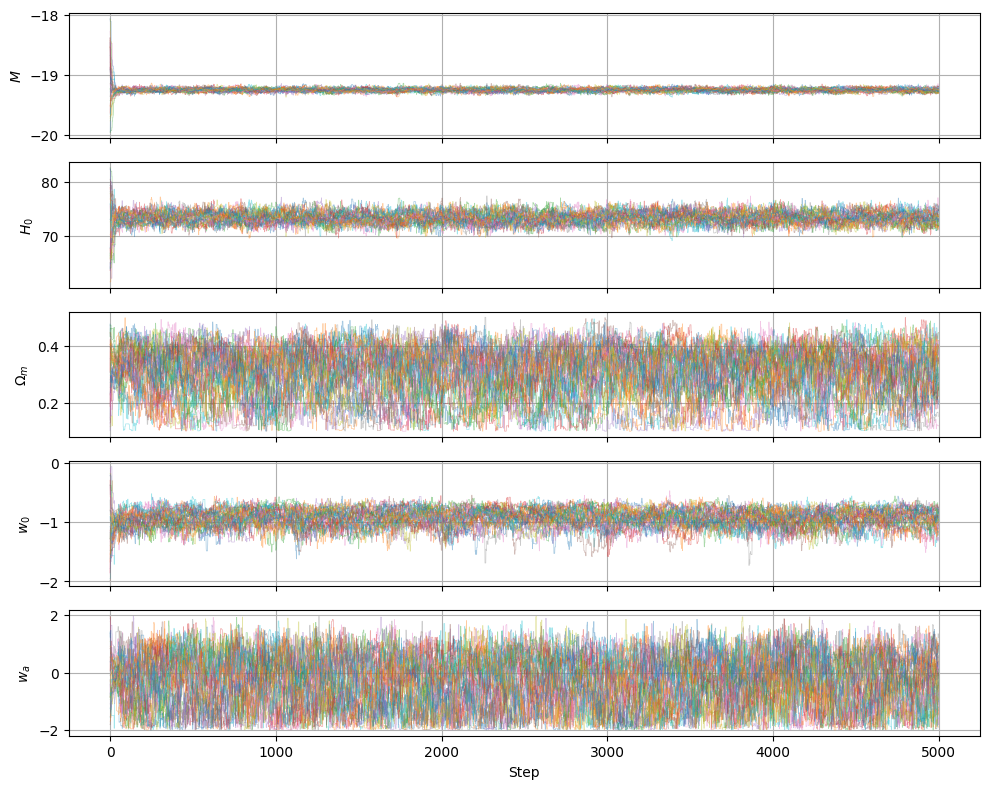

In [7]:
# Load samples and full chain
samples = np.load("samples_CPL_no_transition_5000steps.npy")
full_chain = np.load("full_chain_CPL_no_transition.npy")

# Parameter labels for CPL no-transition model
param_labels = [
    r"$M$", r"$H_0$", r"$\Omega_m$", r"$w_0$", r"$w_a$"
]

# Create chain plot
fig, axes = plt.subplots(5, figsize=(10, 8), sharex=True)

for i in range(5):
    for walker in range(full_chain.shape[1]):
        axes[i].plot(full_chain[:, walker, i], alpha=0.4, lw=0.5)
    axes[i].set_ylabel(param_labels[i])
    axes[i].grid(True)

axes[-1].set_xlabel("Step")
plt.tight_layout()

# Save to file
fig.savefig("chain_plot_CPL_no_transition.png", dpi=300)
plt.show()


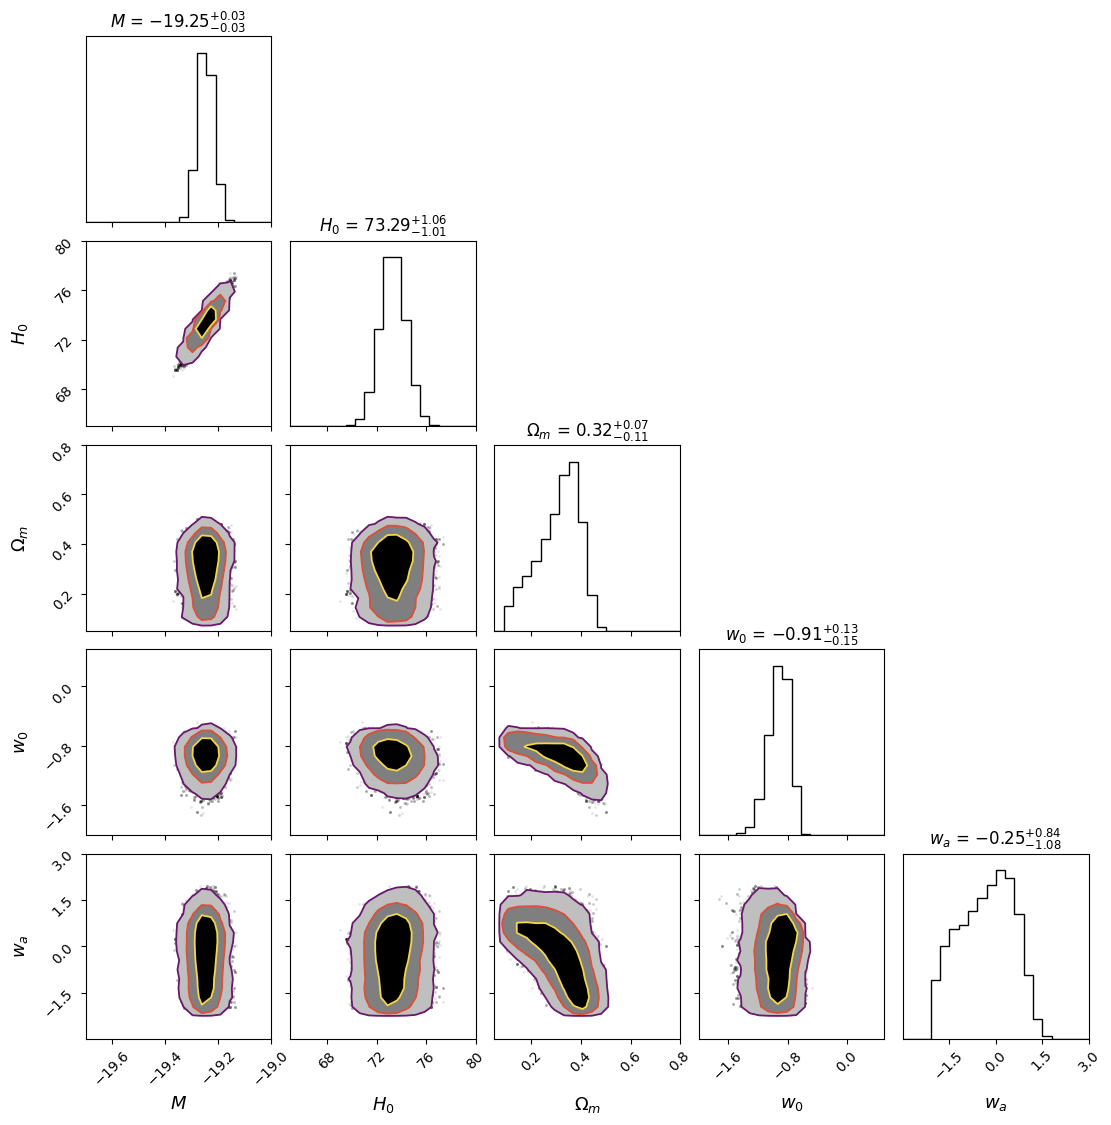

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import corner

# Load samples
samples = np.load("Saved Samples/samples_CPL_no_transition_5000steps.npy")

# Parameter labels for CPL no-transition model
param_labels = [
    r"$M$", 
    r"$H_0$", 
    r"$\Omega_m$", 
    r"$w_0$", 
    r"$w_a$"
]

# Confidence levels
levels = [0.68, 0.95, 0.997]

# Colormap and contour colors
cmap = plt.colormaps["inferno"]
colors = [cmap(i) for i in np.linspace(0.3, 0.9, len(levels))]

# Axis ranges (adjust if needed based on prior volume and posterior spread)
ranges = [
    (-19.7, -19.0),   # M
    (65, 80),         # H_0
    (0.05, 0.80),     # Omega_m
    (-2.0, 0.5),      # w0
    (-3.0, 3.0)       # wa
]

# Create corner plot
fig_cpl = corner.corner(
    samples,
    labels=param_labels,
    show_titles=True,
    title_fmt=".2f",
    levels=levels,
    plot_contours=True,
    fill_contours=True,
    range=ranges,
    contour_kwargs={"colors": colors, "linewidths": 1.3},
    hist_kwargs={"color": colors[0], "edgecolor": "black"},
    label_kwargs={"fontsize": 13},
    title_kwargs={"fontsize": 12},
    max_n_ticks=4,
    use_math_text=True
)

# Adjust layout
plt.subplots_adjust(top=0.95, bottom=0.1, left=0.1, right=0.95, hspace=0.1, wspace=0.1)

# Save plot
fig_cpl.savefig("corner_plot_CPL_no_transition_emcee.png", dpi=300)
plt.show()


# Nested Sampling
## Transition in $M$

In [5]:
def prior_transform_CPL_transition(u):
    """
    Maps unit cube [0,1]^7 → physical parameters for CPL + M-transition model
    """
    Mlow_min, Mlow_max = priors_CPL_transition['M_low']
    Mhigh_min, Mhigh_max = priors_CPL_transition['M_high']
    H0_min, H0_max = priors_CPL_transition['H0']
    Om_min, Om_max = priors_CPL_transition['Omega_m']
    w0_min, w0_max = priors_CPL_transition['w0']
    wa_min, wa_max = priors_CPL_transition['wa']
    dcrit_min, dcrit_max = priors_CPL_transition['d_crit']

    M_low   = Mlow_min + u[0] * (Mlow_max - Mlow_min)
    M_high  = Mhigh_min + u[1] * (Mhigh_max - Mhigh_min)
    H0      = H0_min + u[2] * (H0_max - H0_min)
    Omega_m = Om_min + u[3] * (Om_max - Om_min)
    w0      = w0_min + u[4] * (w0_max - w0_min)
    wa      = wa_min + u[5] * (wa_max - wa_min)
    d_crit  = dcrit_min + u[6] * (dcrit_max - dcrit_min)

    return [M_low, M_high, H0, Omega_m, w0, wa, d_crit]


def log_likelihood_CPL_transition(theta):
    """
    Log-likelihood for CPL + transition model = -0.5 * chi²
    """
    chi2 = chi2_transition_CPL(theta, z, mB, mu_Ceph, is_calibrator, C_inv)
    return -0.5 * chi2


In [6]:
import dynesty
import multiprocessing

# Number of parameters in the model
ndim = 7  # [M_low, M_high, H0, Omega_m, w0, wa, d_crit]

# Launch the sampler with multiprocessing
with multiprocessing.Pool() as pool:
    dsampler_CPL_transition = dynesty.NestedSampler(
        log_likelihood_CPL_transition,     # Log-likelihood function
        prior_transform_CPL_transition,    # Prior transform function
        ndim=ndim,
        nlive=250,                         # Number of live points
        sample='rwalk',                    # Random-walk sampling
        bound='multi',                     # Multi-ellipsoidal bounding
        pool=pool,
        queue_size=multiprocessing.cpu_count()
    )

    dsampler_CPL_transition.run_nested(print_progress=True)
    results_CPL_transition = dsampler_CPL_transition.results

4824it [2:07:51,  1.59s/it, +250 | bound: 48 | nc: 1 | ncall: 132707 | eff(%):  3.831 | loglstar:   -inf < -751.679 <    inf | logz: -769.659 +/-  0.250 | dlogz:  0.001 >  0.259]


In [7]:
logwt = results_CPL_transition.logwt
logz = results_CPL_transition.logz[-1]

weights = np.exp(logwt - logz)
weights /= np.sum(weights)

ess = 1.0 / np.sum(weights**2)
print(f"Effective Sample Size (ESS): {ess:.1f}")

Effective Sample Size (ESS): 1665.7


In [8]:
logZ = results_CPL_transition.logz[-1]
logZerr = results_CPL_transition.logzerr[-1]

print(f"logZ (CPL + M transition): {logZ:.2f} ± {logZerr:.2f}")

logZ (CPL + M transition): -769.66 ± 0.32


In [9]:
samples = results_CPL_transition.samples
logl = results_CPL_transition.logl

# MAP
map_idx = np.argmax(logl)
map_params = samples[map_idx]

# Median and 1σ
medians = np.median(samples, axis=0)
lowers = np.percentile(samples, 16, axis=0)
uppers = np.percentile(samples, 84, axis=0)
minus_sigma = medians - lowers
plus_sigma = uppers - medians

param_names = ["M_low", "M_high", "H0", "Omega_m", "w0", "wa", "d_crit"]
units = ["", "", "km/s/Mpc", "", "", "", "Mpc"]

print("Parameter         MAP Value       Median ± 1σ         Unit")
print("---------------------------------------------------------------")
for name, map_val, med, minus, plus, unit in zip(param_names, map_params, medians, minus_sigma, plus_sigma, units):
    print(f"{name:<17} {map_val:>10.4f}   {med:.4f} +{plus:.4f} -{minus:.4f}   {unit}")


Parameter         MAP Value       Median ± 1σ         Unit
---------------------------------------------------------------
M_low               -19.4111   -19.3863 +0.2688 -0.1132   
M_high              -19.2175   -19.2140 +0.0888 -0.1034   
H0                   74.2000   74.4066 +2.8096 -3.6034   km/s/Mpc
Omega_m               0.1201   0.3216 +0.0981 -0.1292   
w0                   -0.7115   -0.9446 +0.2250 -0.3759   
wa                    0.4629   -0.0926 +1.0430 -1.1941   
d_crit               19.9472   19.4232 +2.3471 -1.8437   Mpc


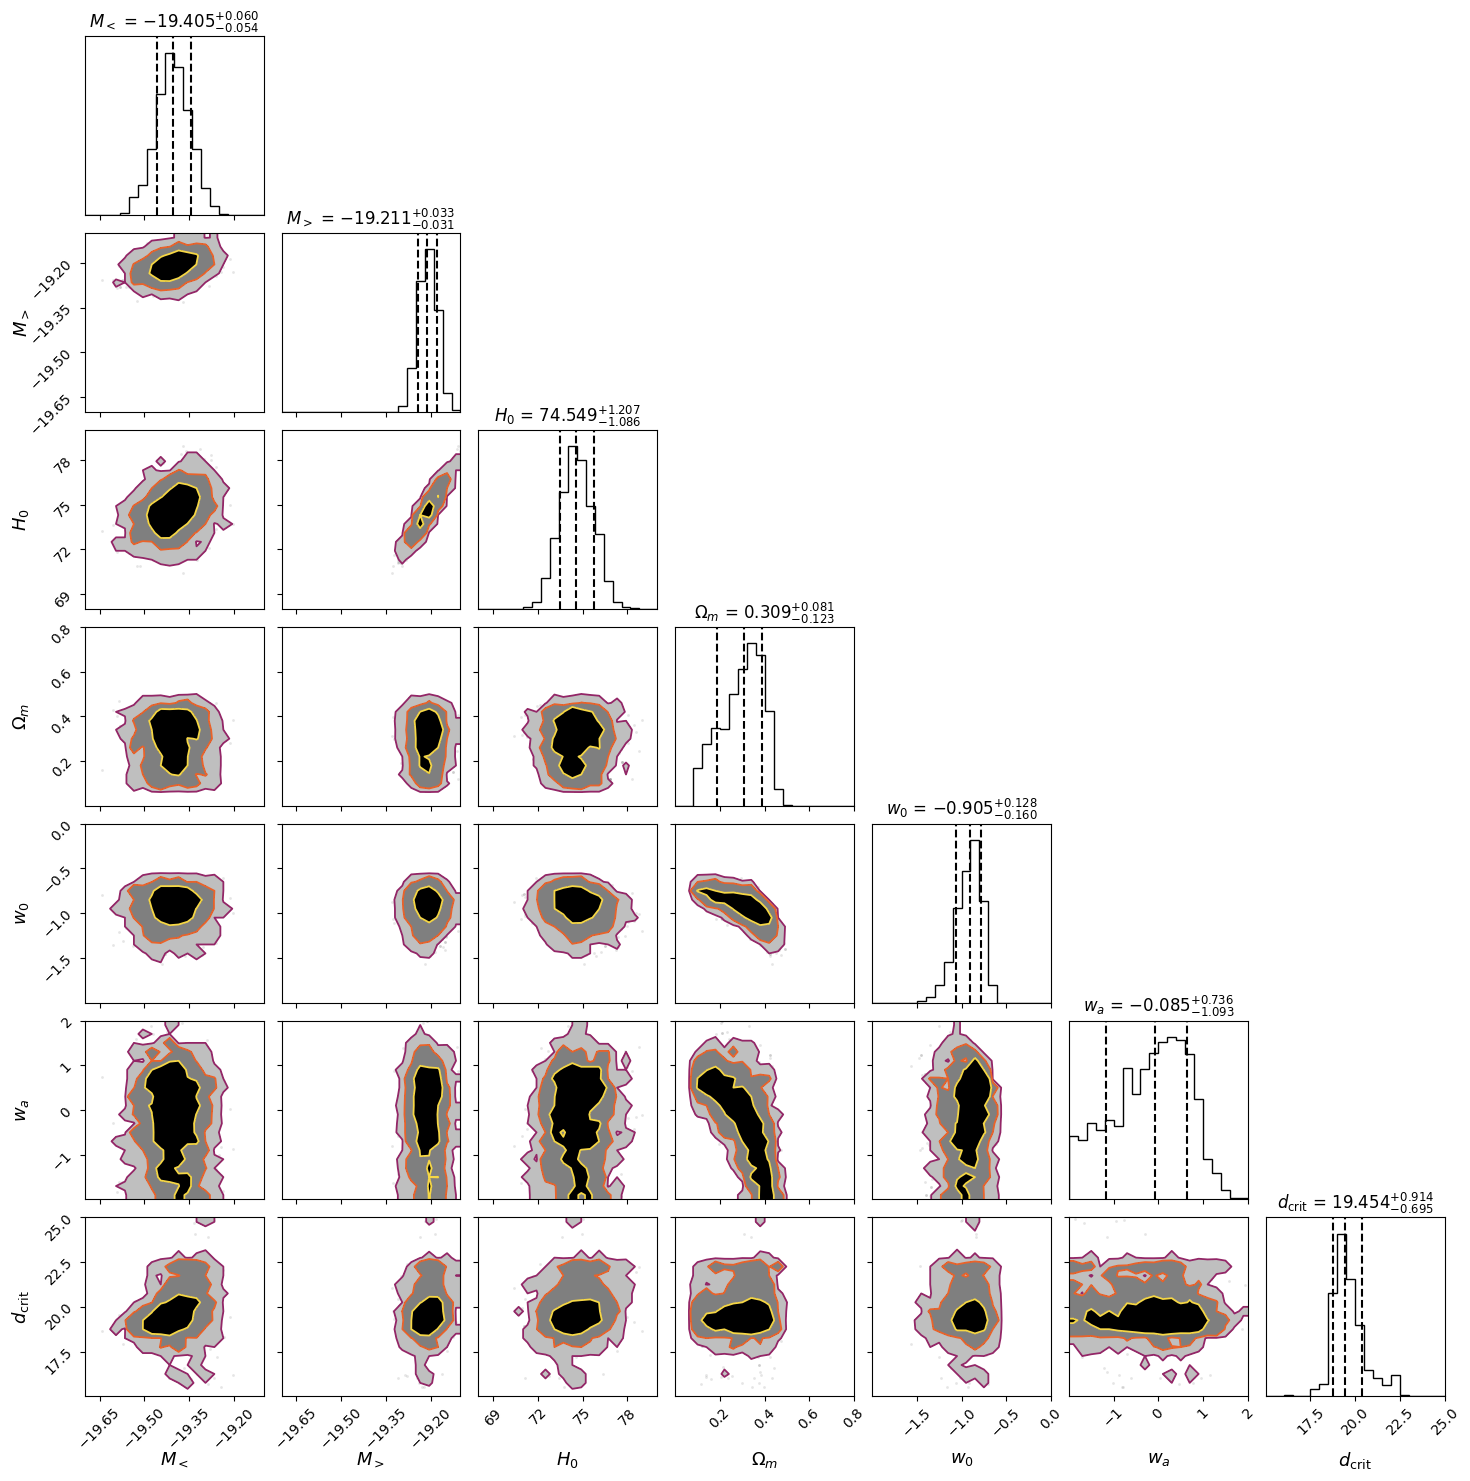

In [29]:
import matplotlib.pyplot as plt
import corner
from dynesty import utils as dyfunc

samples = results_CPL_transition.samples
logwt = results_CPL_transition.logwt
logz = results_CPL_transition.logz[-1]

# Weights and posterior resampling
weights = np.exp(logwt - logz)
weights /= np.sum(weights)
posterior_samples = dyfunc.resample_equal(samples, weights)
np.save("posterior_samples_CPL_transition.npy", posterior_samples)
# Labels and ranges
param_labels = [
    r"$M_{<}$", r"$M_{>}$", r"$H_0$", r"$\Omega_m$",
    r"$w_0$", r"$w_a$", r"$d_{\rm crit}$"
]
ranges = [
    (-19.7, -19.1), (-19.7, -19.1), (68, 80), (0.0, 0.8),
    (-2.0, 0.0), (-2.0, 2.0), (15, 25)
]
levels = [0.68, 0.95, 0.997]
cmap = plt.colormaps["inferno"]
colors = [cmap(i) for i in np.linspace(0.4, 0.9, len(levels))]

fig = corner.corner(
    posterior_samples,
    labels=param_labels,
    range=ranges,
    show_titles=True,
    title_fmt=".3f",
    quantiles=[0.16, 0.5, 0.84],
    levels=levels,
    fill_contours=True,
    plot_contours=True,
    contour_kwargs={"colors": colors, "linewidths": 1.3},
    hist_kwargs={"color": colors[0], "edgecolor": "black"},
    max_n_ticks=4,
    use_math_text=True,
    label_kwargs={"fontsize": 13},
    title_kwargs={"fontsize": 12}
)

plt.subplots_adjust(top=0.95, bottom=0.1, left=0.1, right=0.95, hspace=0.1, wspace=0.1)
fig.savefig("corner_CPL_transition_dynesty.png", dpi=300)
plt.show()


## No-transition in $M$

In [13]:
def prior_transform_CPL_no_transition(u):
    """
    Maps unit cube [0,1]^5 → physical parameters for CPL model without M transition
    """
    M_min, M_max = priors_CPL_no_transition['M']
    H0_min, H0_max = priors_CPL_no_transition['H0']
    Om_min, Om_max = priors_CPL_no_transition['Omega_m']
    w0_min, w0_max = priors_CPL_no_transition['w0']
    wa_min, wa_max = priors_CPL_no_transition['wa']

    M        = M_min + u[0] * (M_max - M_min)
    H0       = H0_min + u[1] * (H0_max - H0_min)
    Omega_m  = Om_min + u[2] * (Om_max - Om_min)
    w0       = w0_min + u[3] * (w0_max - w0_min)
    wa       = wa_min + u[4] * (wa_max - wa_min)

    return [M, H0, Omega_m, w0, wa]

def log_likelihood_CPL_no_transition(theta):
    """
    Log-likelihood = -0.5 * chi² for CPL model without transition in M
    """
    chi2 = chi2_CPL_no_transition(theta, z, mB, mu_Ceph, is_calibrator, C_inv)
    return -0.5 * chi2



In [14]:
ndim = 5  # M, H0, Omega_m, w0, wa

with multiprocessing.Pool() as pool:
    dsampler_CPL_no_transition = dynesty.NestedSampler(
        log_likelihood_CPL_no_transition,
        prior_transform_CPL_no_transition,
        ndim=ndim,
        nlive=250,
        sample='rwalk',
        bound='multi',
        pool=pool,
        queue_size=multiprocessing.cpu_count()
    )
    dsampler_CPL_no_transition.run_nested(print_progress=True)
    results_CPL_no_transition = dsampler_CPL_no_transition.results

3369it [1:20:10,  1.43s/it, +250 | bound: 30 | nc: 1 | ncall: 80720 | eff(%):  4.497 | loglstar:   -inf < -761.288 <    inf | logz: -773.352 +/-  0.209 | dlogz:  0.001 >  0.259]


In [15]:
import numpy as np

logwt = results_CPL_no_transition.logwt
logz = results_CPL_no_transition.logz[-1]

weights = np.exp(logwt - logz)
weights /= np.sum(weights)

ess = 1.0 / np.sum(weights**2)
print(f"Effective Sample Size (ESS): {ess:.1f}")


Effective Sample Size (ESS): 1258.2


In [16]:
logZ_no = results_CPL_no_transition.logz[-1]
logZerr_no = results_CPL_no_transition.logzerr[-1]

print(f"logZ (CPL no transition): {logZ_no:.2f} ± {logZerr_no:.2f}")

logZ (CPL no transition): -773.35 ± 0.29


In [17]:
samples = results_CPL_no_transition.samples
logl = results_CPL_no_transition.logl

# MAP
map_idx = np.argmax(logl)
map_params = samples[map_idx]

# Medians and intervals
medians = np.median(samples, axis=0)
lowers = np.percentile(samples, 16, axis=0)
uppers = np.percentile(samples, 84, axis=0)
minus_sigma = medians - lowers
plus_sigma = uppers - medians

param_names = ["M", "H0", "Omega_m", "w0", "wa"]
units = ["", "km/s/Mpc", "", "", ""]

print("Parameter      MAP Value       Median ± 1σ         Unit")
print("--------------------------------------------------------------")
for name, map_val, med, minus, plus, unit in zip(param_names, map_params, medians, minus_sigma, plus_sigma, units):
    print(f"{name:<14} {map_val:>10.4f}   {med:.4f} +{plus:.4f} -{minus:.4f}   {unit}")


Parameter      MAP Value       Median ± 1σ         Unit
--------------------------------------------------------------
M                -19.2443   -19.2476 +0.1206 -0.1308   
H0                73.3967   73.2948 +3.7215 -4.0033   km/s/Mpc
Omega_m            0.2988   0.3253 +0.0980 -0.1320   
w0                -0.9126   -0.9487 +0.2613 -0.4416   
wa                 0.0342   -0.0969 +1.1330 -1.1783   


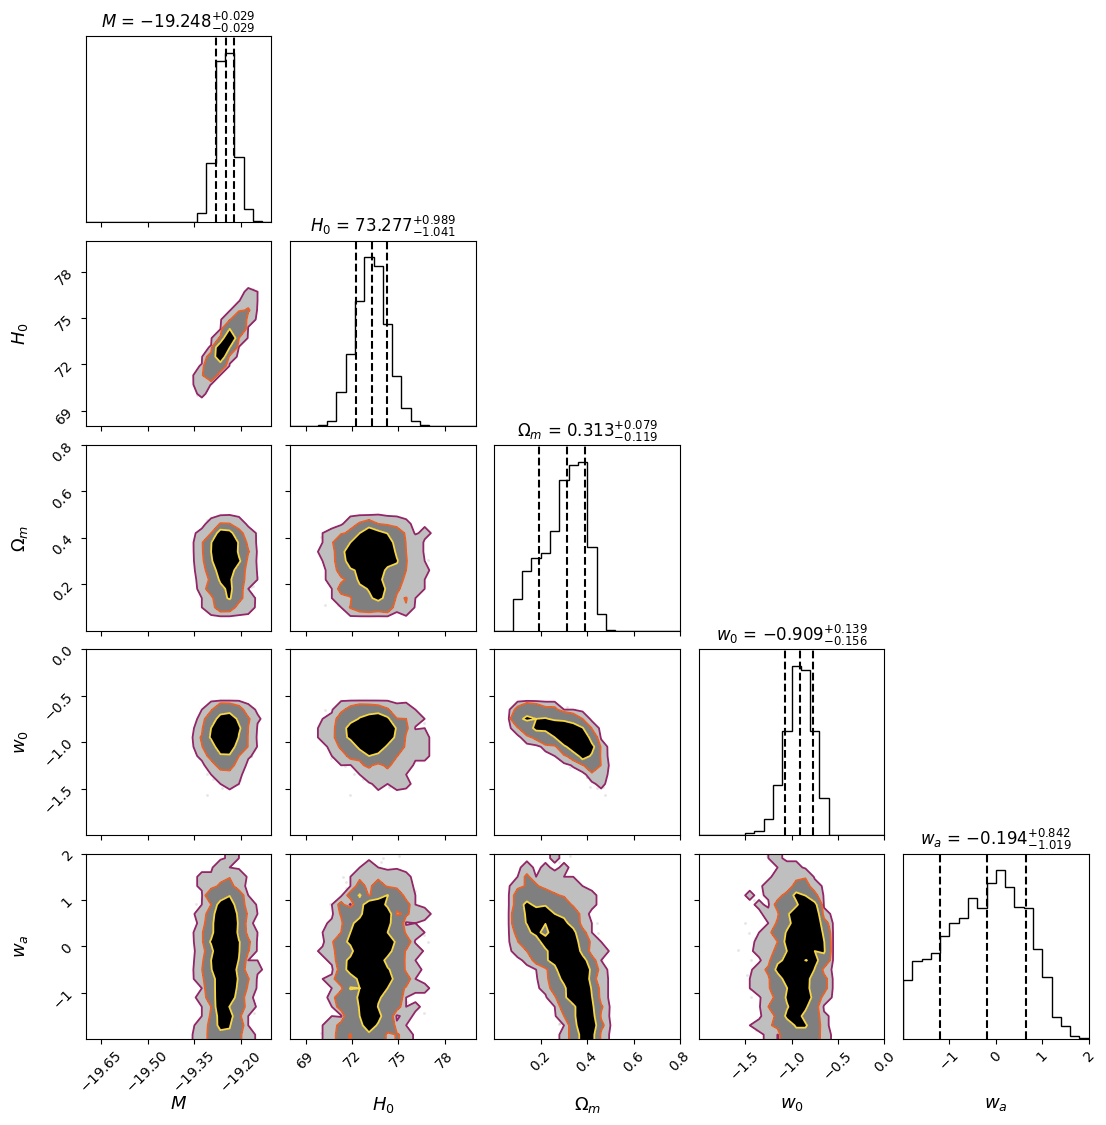

In [20]:
import matplotlib.pyplot as plt
import corner
from dynesty import utils as dyfunc

posterior_samples = dyfunc.resample_equal(samples, weights)
np.save("posterior_samples_CPL_no_transition.npy", posterior_samples)

# Labels and ranges
param_labels = [r"$M$", r"$H_0$", r"$\Omega_m$", r"$w_0$", r"$w_a$"]
ranges = [(-19.7, -19.1), (68, 80), (0.0, 0.8), (-2.0, 0.0), (-2.0, 2.0)]
levels = [0.68, 0.95, 0.997]
cmap = plt.colormaps["inferno"]
colors = [cmap(i) for i in np.linspace(0.4, 0.9, len(levels))]

fig = corner.corner(
    posterior_samples,
    labels=param_labels,
    range=ranges,
    show_titles=True,
    title_fmt=".3f",
    quantiles=[0.16, 0.5, 0.84],
    levels=levels,
    fill_contours=True,
    plot_contours=True,
    contour_kwargs={"colors": colors, "linewidths": 1.3},
    hist_kwargs={"color": colors[0], "edgecolor": "black"},
    max_n_ticks=4,
    use_math_text=True,
    label_kwargs={"fontsize": 13},
    title_kwargs={"fontsize": 12}
)

plt.subplots_adjust(top=0.95, bottom=0.1, left=0.1, right=0.95, hspace=0.1, wspace=0.1)
fig.savefig("corner_CPL_no_transition_dynesty.png", dpi=300)
plt.show()


In [21]:
# Evidence difference
delta_logZ = logZ - logZ_no
delta_logZ_err = np.sqrt(logZerr**2 + logZerr_no**2)

print("Bayesian Model Comparison (CPL):")
print("---------------------------------")
print(f"logZ (No Transition)     = {logZ_no:.2f} ± {logZerr_no:.2f}")
print(f"logZ (With Transition)   = {logZ:.2f} ± {logZerr:.2f}")
print(f"ΔlogZ (Transition - No)  = {delta_logZ:.2f} ± {delta_logZ_err:.2f}")

# Jeffreys' scale
if delta_logZ < 1:
    interpretation = "Inconclusive preference"
elif delta_logZ < 2.5:
    interpretation = "Weak evidence for transition model"
elif delta_logZ < 5:
    interpretation = "Moderate evidence for transition model"
else:
    interpretation = "Strong evidence for transition model"

print(f"Interpretation: {interpretation}")

# Bayes factor
BF = np.exp(delta_logZ)
print(f"Bayes Factor (Transition / No) = {BF:.2f}")


Bayesian Model Comparison (CPL):
---------------------------------
logZ (No Transition)     = -773.35 ± 0.29
logZ (With Transition)   = -769.66 ± 0.32
ΔlogZ (Transition - No)  = 3.69 ± 0.43
Interpretation: Moderate evidence for transition model
Bayes Factor (Transition / No) = 40.15
